In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import math as m
import scipy.integrate as scint
pi = 4*m.atan(1.)

from IPython import display

import matplotlib as mpl

mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from typing import List
from collections import Counter

# The SIR model

We will focus on the SIR model, probably the most studied model in computational epidemics. In its simplest form, the SIR model can be defined as follows. A large population of $N$ individuals is divided into three classes:
+ **Susceptible** individuals (S): those who do not have the disease but can get it.
+ **Infected** individuals (I) : those who have the disease.
+ **Recovered** individuals (R): those who cannot get the disease anymore.

The basic dynamics of the model are simple as well:
1. Susceptible individuals might get infected if they are in contact with an infected individual. 
2. Infected individuals become recovered after some time. 

Notice that individuals can only go from *S* to *I* and from *I* to *R*. We will also assume that infective individuals have contacts with randomly chosen individuals of all states at an average rate $\beta$ per unit time, and recover and acquire immunity (or die) at an average rate $\gamma$ per unit time. 


### Fully mixed population
If we assume a very large population that is **fully mixed**, then the model can be descrived by a set of coupled nonlinear differential equations:  


<img src="attachment:image.png" width="400"> 

### Exercise 5.1
The `scipy.integrate` library has a function `solve_ip` that can be used to solve initial value problems for systems of ODES.
The documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html).

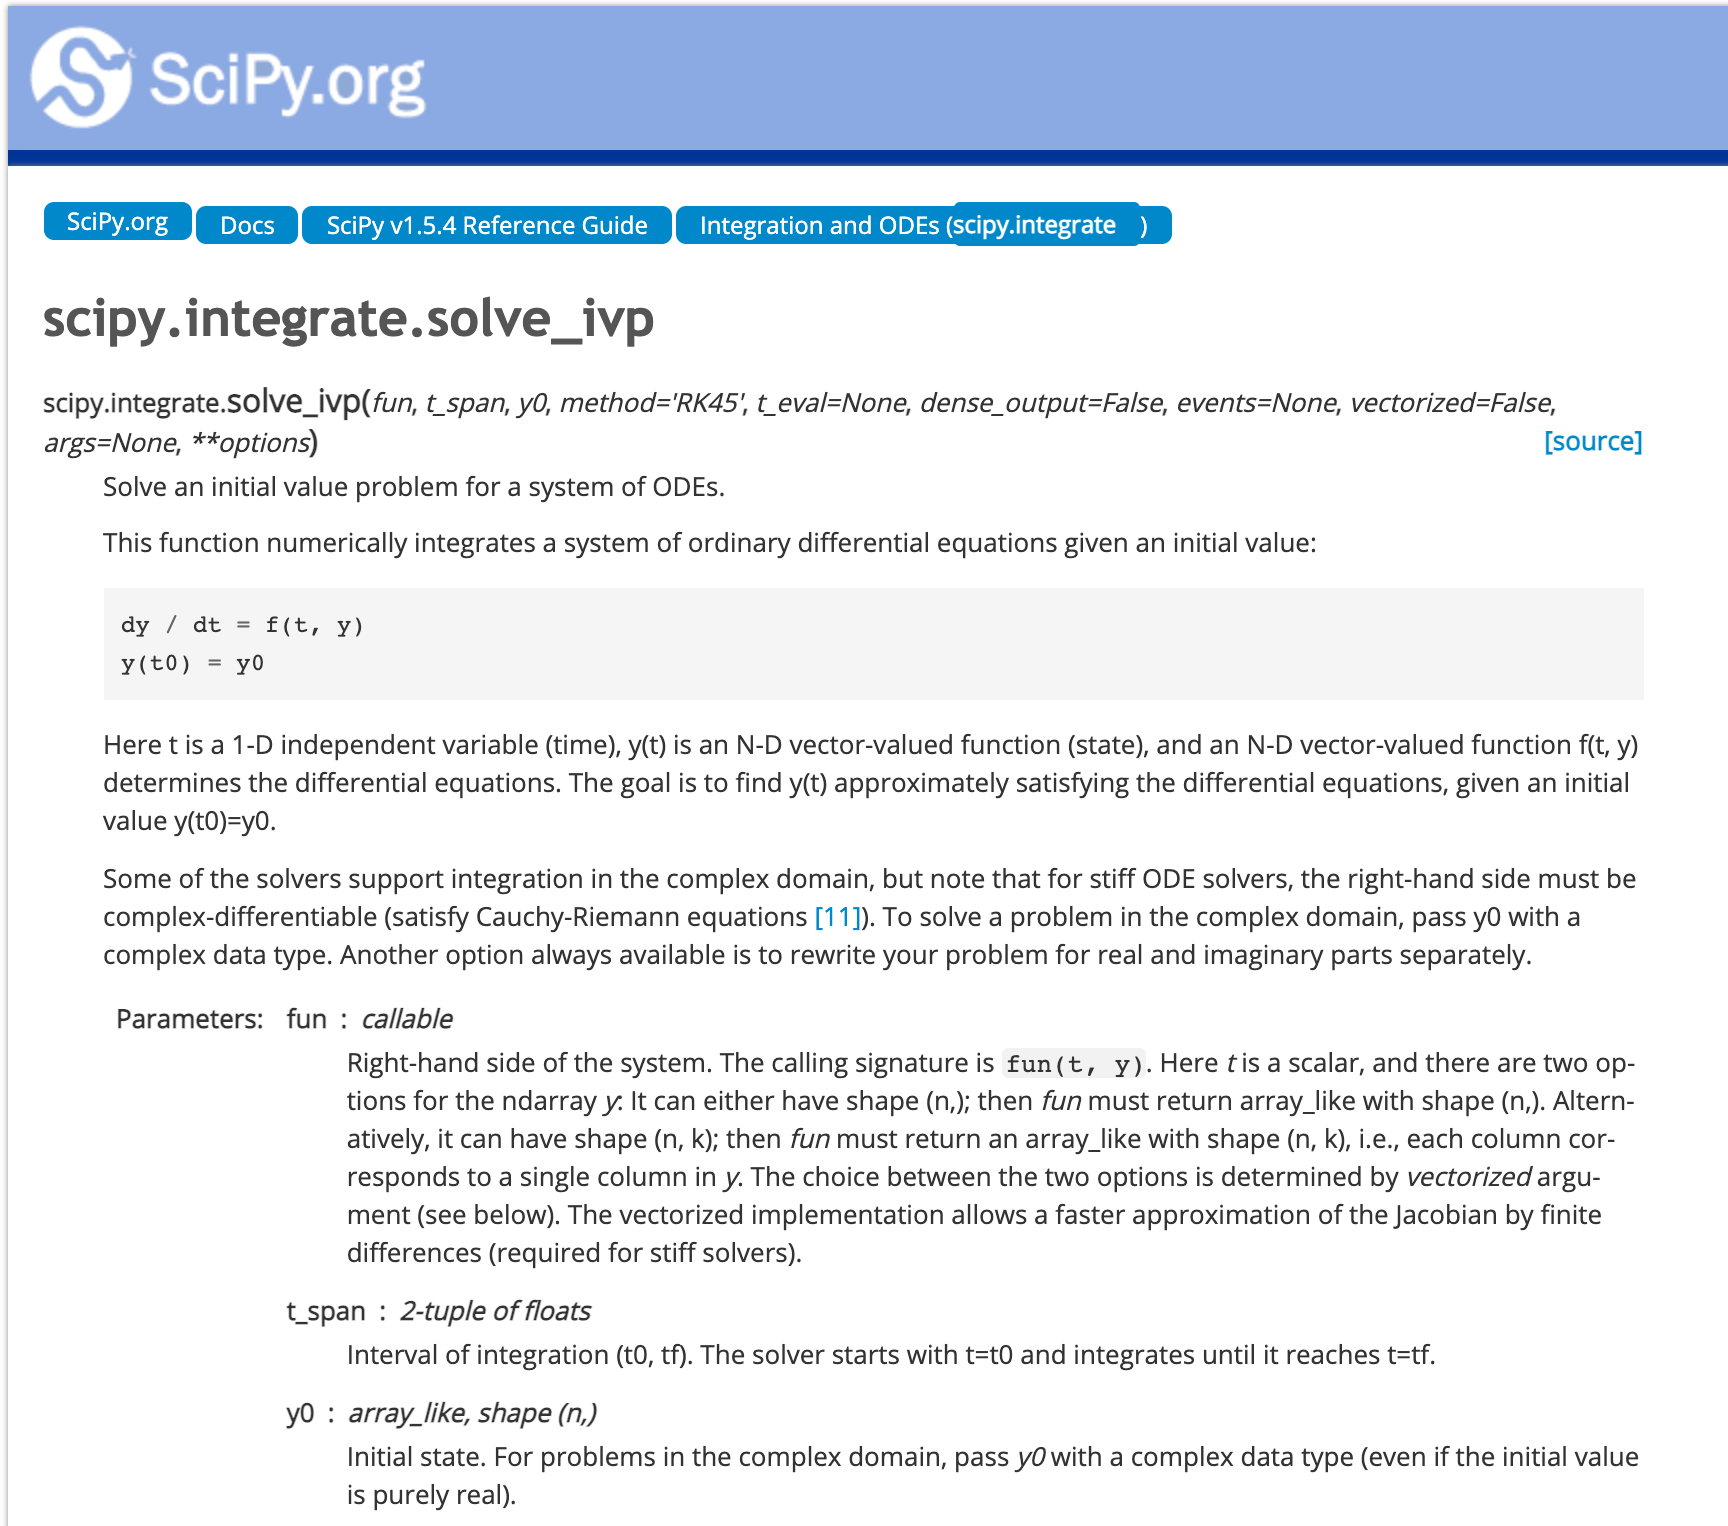


[ 0.          0.10001999  1.06609106  2.30431769  3.64528981  5.0274784
  6.42658963  7.83271453  9.2417576  10.        ]
[[1.00000000e+00 1.10519301e+00 2.90405980e+00 1.00174032e+01
  3.82917453e+01 1.52525445e+02 6.17906340e+02 2.52084574e+03
  1.03142124e+04 2.20161251e+04]]


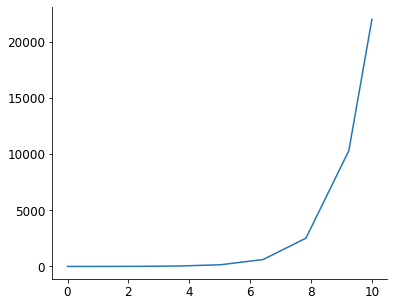

In [2]:
def f(t,y):
    f=y
    return f
y0=[1]
ode_res=scint.solve_ivp(f,[0.,10.],y0)
t=ode_res.t
y=ode_res.y
print(t)
print(y)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(
    t,
    y[0])

In [3]:
def odes_SIR(t, y):
    """
    The main ODE equations of the SIR model
    """
    (S, I, R) = y
    #t=0
    N=S+I+R
    f=np.array([
        - beta * S* (float(I)/float(N)) ,
        beta * S* (float(I)/float(N)) - gamma*I,
        gamma*I,        
    ])
    return f

Read the documentation and try to understand how to use `solve_ivp`. The key bit is to notice that we have to write a **function** `f(t, y)`  whose first argument is the timepoint `t` and whose second argument `y` is a numpy array. In our case, y will have dimension 3. Do you see why?


The Initial Value Problem to be solved is then simply

```text
    dy / dt = f(t, y)
    y(t0) = y0
```


Write a function `ode_SIR` that represents the system of differential equations of a SIR model and follows the specification of `solve_ivp`.

### Exercise 5.2
Use `solve_ivp` and your `ode_SIR` function to study the behaviour of the SIR model for different values of the parameters, and describe your findings with a short paragraph.

In [4]:
# set parameters
beta=0.4
gamma=0.05
y0 = ((100-3./13.), 3./13., 0)
y=y0
tmax = 100
t=0

In [5]:
# solve ODE
ode_result = scint.solve_ivp(odes_SIR,(0,tmax),y0)

In [6]:
# extract results
assert ode_result.success
t_range = ode_result.t
S, I, R = ode_result.y

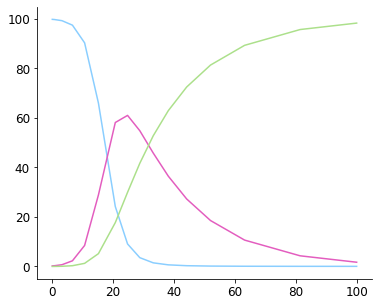

In [7]:
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}

# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(
    t_range,
    S,
    c=SIR_colors["S"])
ax.plot(
    t_range,
    I,
    c=SIR_colors["I"])
ax.plot(
    t_range,
    R,
    c=SIR_colors["R"])


The number of infected indivduals grows fast enough until it plateau at some point, when the number of healthy people is too little to feed its growth. It then decresases until it reaches 0

### SIR model on a network
The ODE approximation of the SIR model is not very realistic because it assumes a fully mixed population.
The fact that we do not interact randomly with one another, but rather have complex social structures, schools, commuting etc is what makes the whole thing much more difficult.

To explorer the importance of the **contact network** for the spread of a disease, we will implement a simple discrete-time SIR model that runs on an arbitrary network or graph. To do so, we will define a class `SIRonGraph` that holds together the **graph** where the SIR model runs and the **methods** (aka functions) that implement the SIR dynamics.

We will use the `networkx` module, a well-known python library to work with networks data. To check if you have it installed in your computer, run

In [8]:
import networkx as nx

If you get a `ModuleNotFoundError`, that means that you need to install it before continuing. In most cases, simply opening a terminal and running

```bash
> pip install networkx
```

should work. Additional installation instructions can be found [here](https://networkx.org/documentation/stable/install.html).

Networkx provides you the `Graph` type, that is, a kind of variable that represents a graph or network. Let us try it:

In [9]:
G = nx.Graph()

Networks have nodes and edges. Let us add some. Here we use letters to label the nodes, but integers would work as well.

In [10]:
G.add_nodes_from(["A", "B", "C", "D"])

In [11]:
G.add_edges_from([("A", "B"), ("B", "C"), ("C", "A"), ("C", "D"),("D","B"),("A","D")])

Now we want to have a look at our network. Networkx gives us some handy functions!

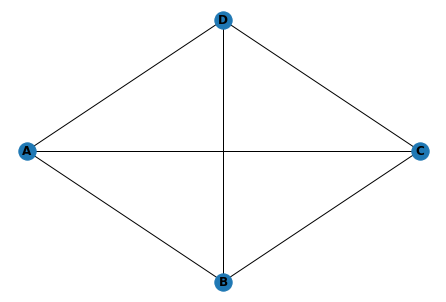

In [12]:
#nx.draw_networkx(G)
nx.draw_shell(G, with_labels=True, font_weight="bold")

Finally, networks can also hold some data on their nodes on edges. These are called **attributes** and are very useful. Let us create one:

In [13]:
initial_status = {
    "A": "S",
    "B": "S",
    "C": "I",
    "D": "S"
}

In [14]:
nx.set_node_attributes(G, initial_status, name="kind")

Now G carries the attribute *kind* with it. We can get the values of attributes of individual nodes easily:

In [15]:
G.nodes["C"]["kind"]

'I'

We can also modify the value of an attribute. Let us suppose node C infects node B. The we could do:

In [16]:
G.nodes["B"]["kind"] = "I"

If we need to get the attribute of all nodes, we can do it at once as follows:

In [17]:
current_status = nx.get_node_attributes(G, "kind")

In [18]:
current_status

{'A': 'S', 'B': 'I', 'C': 'I', 'D': 'S'}

### The SIR model as a python class

We will now create a class `SIRonGraph` to represent a SIR model on an arbitrary network. A class holds together data and functions (callled methods), and is exactly what we need in this case: a network and some functions that implement the SIR dynamics on it.

Classes can be a bit confusing at the beginning, but all you need to understand is that `self` means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how `self` works.

In [19]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name
    
    def set_x(self, x):
        self.x = x
        
    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x
    

In [20]:
model1 = Model(name="my first model")
model2 = Model(name="another model")

In [21]:
model1.set_x(3)
model2.set_x(-2)

In [22]:
model1.increment_x()

In [23]:
model1.show_x()

4

In [24]:
model2.show_x()

-2

We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [25]:
model1.name

'my first model'

So, let us go back to our SIR model. The input to create a new SIR model on an arbitrary network is the following:

1. The graph onto which we want to run the SIR model.
2. A list of initially infected nodes.
3. The coefficient $\beta$
4. The coefficient $\gamma$

So, we create a class `SIRonGraph` that, when initialized, simply stores the input.

In [26]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """
        Initialize a SIR model on a network. 
        """
        # store parameters
        self.beta = beta
        self.gamma = gamma
        self.network = network

Let us try it. First we need to create a graph! Networkx has some functions to generate standard graphs. We could start with a lattice graph, for instance.

In [27]:
# 2 rows, 3 columns
G = nx.hexagonal_lattice_graph(2, 3)

Notice that nodes are labelled with a tuple of integers `(col, row)` and that `G` comes with a nice `pos` node attribute, which we can use to nicely plot the network.

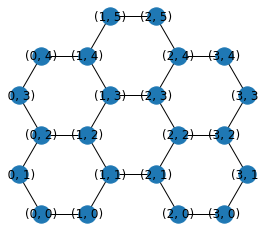

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_aspect(1)
ax.set_axis_off()

pos = nx.get_node_attributes(G, 'pos')
nx.draw_networkx(G, pos=pos)

Now we can create our first model

In [29]:
model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1,2),(2,3)])

Notice that you can retrieve all the information that is stored in `self`. 

In [30]:
model.network

Notice that `model.network` is not a copy of `G`: it is exactly the same object, point to the same memory address!

In [31]:
G

G.nodes

G.edges[(0,0),(0,1)]
nx.set_edge_attributes(G,0,name="dio")
G.edges

EdgeView([((0, 0), (0, 1)), ((0, 0), (1, 0)), ((0, 1), (0, 2)), ((0, 2), (0, 3)), ((0, 2), (1, 2)), ((0, 3), (0, 4)), ((0, 4), (1, 4)), ((1, 0), (1, 1)), ((1, 1), (1, 2)), ((1, 1), (2, 1)), ((1, 2), (1, 3)), ((1, 3), (1, 4)), ((1, 3), (2, 3)), ((1, 4), (1, 5)), ((1, 5), (2, 5)), ((2, 0), (2, 1)), ((2, 0), (3, 0)), ((2, 1), (2, 2)), ((2, 2), (2, 3)), ((2, 2), (3, 2)), ((2, 3), (2, 4)), ((2, 4), (2, 5)), ((2, 4), (3, 4)), ((3, 0), (3, 1)), ((3, 1), (3, 2)), ((3, 2), (3, 3)), ((3, 3), (3, 4))])

In [32]:
model.beta

0.3

In [33]:
model.gamma

0.1

### Exercise 5.3
Our model should do a few more things at initialization:
1. Checking that $\beta$ and $\gamma$ have sensible values.
2. Making sure that all elements in input list of inital infected are really nodes of the network.
2. Creating a node attribute called "kind" with value "S" for all nodes except for those in the list of `inital_infected`

Extend the SIRonGraph code below and implement points 1 and 2 in the ``__init__`` method.

In [34]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        for i in initial_infected:
            check=False
            for j in network.nodes:
                if(np.array_equal(j,i)):
                    check=True
            assert(check)
        initial_values=np.zeros(len(network))
    
        # set initial status of nodes as node att
        nx.set_node_attributes(network,initial_values,name="kind")
        for nodo in network:
            for inf in initial_infected:
                if(np.array_equal(nodo,inf)):
                    network.nodes[nodo]["kind"] = "I"
            if(network.nodes[nodo]["kind"] != "I"):
                network.nodes[nodo]["kind"] = "S"
           
        # make sure params make sense 
        assert((gamma < 1) and (beta < 1))
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma

In [35]:

model = SIRonGraph(network=G, beta=0.3, gamma=0.1, initial_infected=[(1, 3)])

<ipython-input-34-6528ba9d2797>:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


### Exercise 5.4
1. Create a function to visualize a hexagonal lattice model, with nodes colored by type. Your function should take as input the model instance (object of kind SIRonGraph) and display the network, coloring S, I and R nodes with different colors.
2. Show that your function works for a few examples with different input graph sizes and different sets of initially infected nodes.

**Tip**: look into the networkx documentation! It is [here](https://networkx.org/documentation/stable/reference/drawing.html).

In [36]:
def show_hex_model(model, ax=None):
    # creates a figure if no axis was passed
    ax_was_none = ax is None
    if ax_was_none:
        # create a figure
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.set_aspect(1)
        ax.set_axis_off()
        
        
    # get the positions and kind of nodes
    pos = nx.get_node_attributes(model.network, 'pos')
    kinds=nx.get_node_attributes(model.network, 'kind')

    # prepare a list of colors for the nodes using the kinds dict
    colori = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
    }
    color_map = [colori[model.network.nodes[nodo]["kind"]]  for nodo in model.network]
    # draw the network
    nx.draw_networkx(G, node_color=color_map,pos=pos)    
    # returns the new figure if it was created here
    if ax_was_none:
        return fig, ax

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

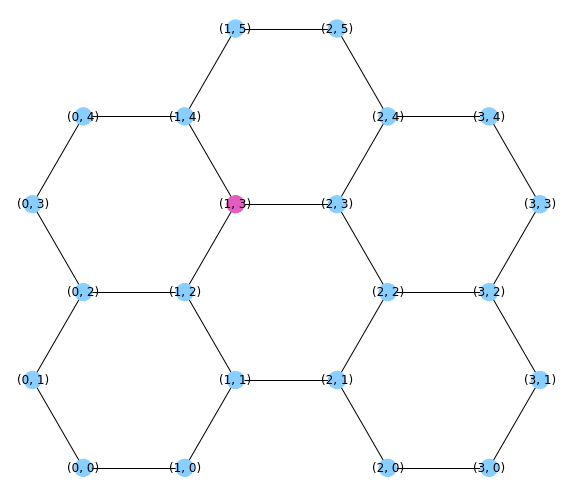

In [37]:
show_hex_model(model, ax=None)

### SIR dynamics as class methods
Now we want to be able to run the SIR dynamics on our `SIRonGraph` objects. To simplify things, we  consider **discrete time** simulation, so that at each time-step:
+ Infected individuals have a chance to recover, and they do so with probability $\gamma$.
+ Susceptible individuals can be infected by any of the infected individuals to which they are connected. This happens with probability $\beta$ for each S-I edge.

### Exercise 5.5
Implement the dynamics of the SIR model as methods of your `SIRonGraph` class. You might want to implement two methods separately, as follows:

+ `_step(self)`: this method implements one single time-step, as descrived above.
+ `run(self, num_timesteps: int)`: this method (for now) simply calls `_step` repeatedly.

You will see, in a while, that it is useful to organize things as we are doing.

In [38]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        for i in initial_infected:
            check=False
            for j in network.nodes:
                if(np.array_equal(j,i)):
                    check=True
            assert(check)
        initial_values=np.zeros(len(network))
    
        # set initial status of nodes as node att
        nx.set_node_attributes(network,initial_values,name="kind")
        for nodo in network:
            for inf in initial_infected:
                if(np.array_equal(nodo,inf)):
                    network.nodes[nodo]["kind"] = "I"
            if(network.nodes[nodo]["kind"] != "I"):
                network.nodes[nodo]["kind"] = "S"
           
        # make sure params make sense 
        assert((gamma < 1) and (beta < 1))
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma

        
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"]== 'I':
                if(np.random.uniform() < self.gamma):
                        self.network.nodes[node]["kind"] = 'R'
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            infetto= False
            for nodo in edge:
                if self.network.nodes[nodo]["kind"] == 'I':
                    infetto=True
            if infetto:
                for nodo in edge:
                    if self.network.nodes[nodo]["kind"] == 'S':
                        if (np.random.uniform() < self.beta):
                            self.network.nodes[nodo]["kind"] = "I"
                            

        
    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for i in range(num_timesteps):
            self._step()

### Exercise 5.6
Use your visualization function to show the evolution of a SIR model running in a hex lattice. You should decide the system size, number of timesteps and other parameterrs wisely to show that your code works properly.

<ipython-input-38-741d0b697ae9>:25: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

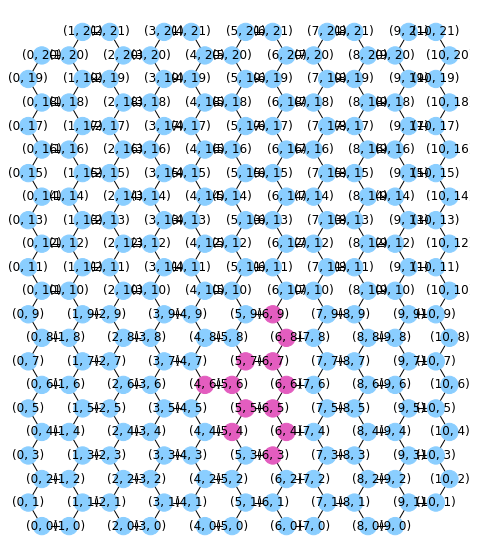

In [39]:
G = nx.hexagonal_lattice_graph(10, 10)
model = SIRonGraph(network=G, initial_infected=[(5, 5)], beta=0.3, gamma=0.05)



model.run(6)

show_hex_model(model, ax=None)

[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>
 <AxesSubplot:> <AxesSubplot:>]


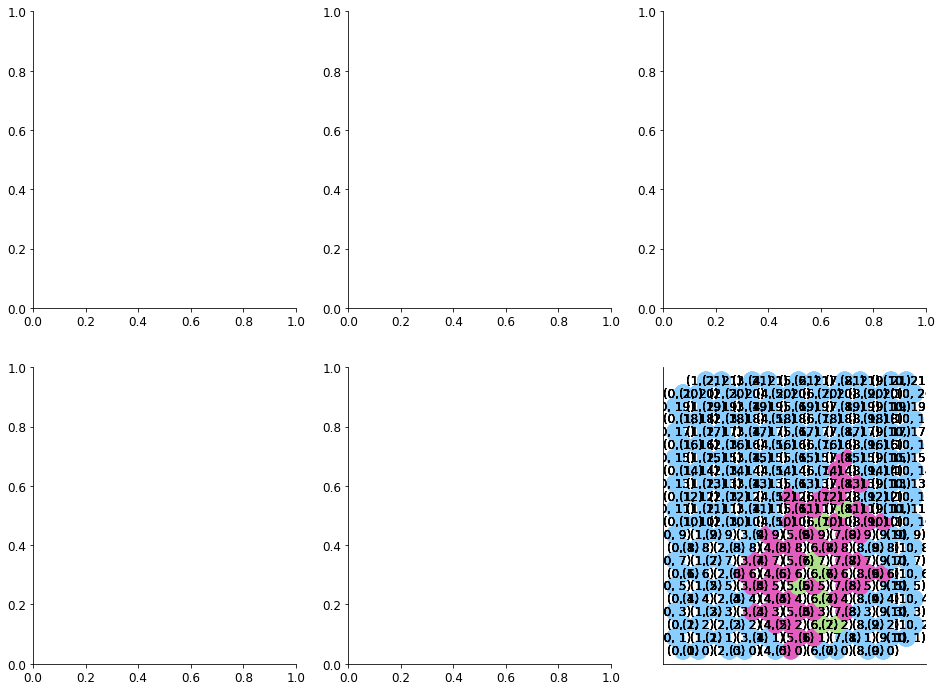

In [40]:
fig, axx = plt.subplots(2, 3, figsize=(16, 12))
axx = axx.reshape(-1)
print(axx)
for ax in axx:
    ### plot model status on axis ax
    show_hex_model(model, ax)
    
    ### run the model for some timesteps
    model.run(1)

### Storing SIR evolution as a class attribute
Now our class can run the SIR dynamics, but it doesn't "remember" the whole evolution of the simulation: only the final state is available. One way of storing some quantities of interest during the simulation is as follows:

1. Create an empty list at initialization.
```python
class SIRonGraph:
     def __init__(self, G: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
         ...
         # empty list, we will add info durring the simulation
         self.history = []
         ...
```

2. Create a _log() method that, when called, computes the information we want to store and adds it to the self.history list.

```python
   def _log(self):
        # do computations
        var1 = ...
        var2 = ...
        ...
        
        # create a block of info as list
        info = [var1, var2, ...]
        # or as a dict
        info = {
            "var1": var1,
            "var2": var2,
            ...
        }
        # or using any other scheme you like
        info = ...
        
        # add the info block to the history log
        self.history.append(info)
```

3. Call the ._log() method every time you want to store the variables of interest. That could be at every timestep or once in a while only. 
It is also wise to call `._log()` once at initialization, to store the initial status. 
```python
   def __init__(self, ...):
         ...
         self._log()
        
   def run(self, num_timesteps: int):
         """Run the SIR dynamics for some time."""
         ...
         for _ in range(num_timesteps):
              self._step()
              self._log()
         ...
```

### Exercise 5.7
1. Modify your SIRonGraph class so that it stores the number of **S**, **I** and **R** individuals at each timestep.
2. Simulate the SIR model in a network of your choice, and plot the evolution of the system (S, I, R) over time. Try to choose the parameters wisely, so that a typical epidemic wave can be seen.

In [41]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        for i in initial_infected:
            check=False
            for j in network.nodes:
                if(np.array_equal(j,i)):
                    check=True
            assert(check)
        initial_values=np.zeros(len(network))
    
        # set initial status of nodes as node att
        nx.set_node_attributes(network,initial_values,name="kind")
        for nodo in network:
            for inf in initial_infected:
                if(np.array_equal(nodo,inf)):
                    network.nodes[nodo]["kind"] = "I"
            if(network.nodes[nodo]["kind"] != "I"):
                network.nodes[nodo]["kind"] = "S"
           
        # make sure params make sense 
        assert((gamma < 1) and (beta < 1))
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma

    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        self.history.append
        self._log()
        

    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"]== 'I':
                if(np.random.uniform() < self.gamma):
                        self.network.nodes[node]["kind"] = 'R'
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            infetto= False
            for nodo in edge:
                if self.network.nodes[nodo]["kind"] == 'I':
                    infetto=True
            if infetto:
                for nodo in edge:
                    if self.network.nodes[nodo]["kind"] == 'S':
                        if (np.random.uniform() < self.beta):
                            self.network.nodes[nodo]["kind"] = "I"
    def _log(self):
        # do computations
        
        sani=0
        infe=0
        recu=0
        for node in self.network:
            if self.network.nodes[node]["kind"] =="S":
                sani += 1
            if self.network.nodes[node]["kind"] =="I":
                infe += 1
            if self.network.nodes[node]["kind"] =="R":
                recu += 1
        info = [sani,infe,recu]
        self.history.append(info)

    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for i in range(num_timesteps):
            self._step()
            self._log()

In [42]:
# create the model
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.561,
    gamma=0.0453
)

<ipython-input-41-7d472908dcba>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


In [43]:
# run the model for some time
model.run(200)

In [44]:
# extract evolution of S, I, R from model.history
print(model.history)

[[1297, 3, 0], [1276, 24, 0], [1230, 68, 2], [1111, 180, 9], [956, 324, 20], [827, 440, 33], [715, 528, 57], [581, 639, 80], [471, 720, 109], [370, 779, 151], [284, 824, 192], [227, 857, 216], [140, 892, 268], [98, 896, 306], [65, 885, 350], [53, 854, 393], [38, 832, 430], [28, 795, 477], [18, 763, 519], [12, 737, 551], [7, 709, 584], [4, 689, 607], [2, 661, 637], [2, 632, 666], [2, 595, 703], [2, 572, 726], [2, 545, 753], [2, 505, 793], [2, 482, 816], [2, 464, 834], [2, 443, 855], [2, 428, 870], [2, 410, 888], [2, 395, 903], [2, 374, 924], [2, 362, 936], [2, 346, 952], [2, 335, 963], [2, 313, 985], [2, 305, 993], [2, 288, 1010], [2, 278, 1020], [2, 261, 1037], [2, 251, 1047], [2, 237, 1061], [2, 224, 1074], [2, 218, 1080], [2, 205, 1093], [2, 197, 1101], [2, 184, 1114], [2, 180, 1118], [2, 171, 1127], [2, 165, 1133], [2, 157, 1141], [2, 150, 1148], [2, 145, 1153], [2, 140, 1158], [2, 131, 1167], [2, 125, 1173], [2, 121, 1177], [2, 117, 1181], [2, 110, 1188], [2, 103, 1195], [2, 97, 12

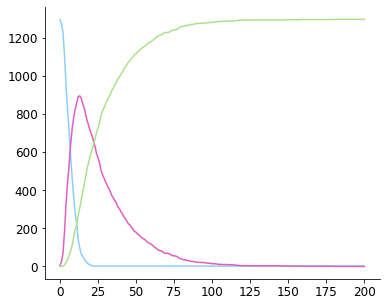

In [45]:
# plot S,I,R vs time
# OPTIONAL to get the same colors for S, I, R plots over all the notebook, we can define a dictionary of colors
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}
dati=model.history
sani= [dati[t][0] for t in range(len(dati))]
infetti= [dati[t][1] for t in range(len(dati))]
recuperati= [dati[t][2] for t in range(len(dati))]
tempi=range(len(dati))
# plot solution (S, I, R) on y axis, time on x-axis
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(
    tempi,
    sani,
    c=SIR_colors["S"])
ax.plot(
    tempi,
    infetti,
    c=SIR_colors["I"])
ax.plot(
    tempi,
    recuperati,
    c=SIR_colors["R"])


### Exercise 5.8
Which kind of network could give results equivalent to the ODE solution of the first part of the notebook? Explain why.

To have the same results, the network should be fully mixed, therefore each node would need to be linked to every other node

### Exercise 5.9
Compare the ODE solution with simulation results on the appropiate network. Do you see differences? If so, explain why.
Remember to properly add labels and legends to all your plots!

In [46]:
# define your model
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.4,
    gamma=0.05
)

<ipython-input-41-7d472908dcba>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


In [47]:
# run the model, extrarct results

In [48]:
# optional: maybe more than one simulation and then average?
tentativi=10
lung_sim=100
dati=np.zeros((lung_sim,3))
for i in range(tentativi):
    model = SIRonGraph(
        network=nx.hexagonal_lattice_graph(30, 20),
        initial_infected=[(10, 10), (2, 2), (2, 5)],
        beta=0.4,
        gamma=0.05
        )
    model.run(lung_sim)
    for j in range(lung_sim):
        for k in range(3):
            dati[j][k]+=(model.history[j][k]/float(tentativi))

<ipython-input-41-7d472908dcba>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


Text(0.5, 1.0, 'Metodo a rete - simulazione con i nodi')

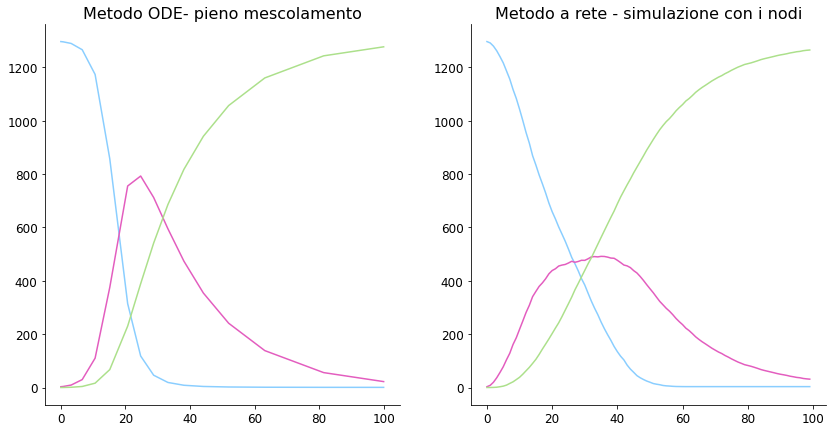

In [49]:
# plot results togetherr with old ODE results
SIR_colors = {
    "S": "#8aceff",
    "I": "#e35dbf",
    "R": "#ace08b"
}
sani= [dati[t][0] for t in range(len(dati))]
infetti= [dati[t][1] for t in range(len(dati))]
recuperati= [dati[t][2] for t in range(len(dati))]
tempi=range(lung_sim)
fig, axx = plt.subplots(1, 2, figsize=(14, 7))
axx[1].plot(
    tempi,
    sani,
    c=SIR_colors["S"])
axx[1].plot(
    tempi,
    infetti,
    c=SIR_colors["I"])
axx[1].plot(
    tempi,
    recuperati,
    c=SIR_colors["R"])
axx[0].plot(
    t_range,
    S*13,
    c=SIR_colors["S"])
axx[0].plot(
    t_range,
    I*13,
    c=SIR_colors["I"])
axx[0].plot(
    t_range,
    R*13,
    c=SIR_colors["R"])
axx[0].set_title('Metodo ODE- pieno mescolamento')
axx[1].set_title('Metodo a rete - simulazione con i nodi')

We see a similar evolution, however the I curve flattens earlier, because of the little mixing,that reduces the effective infectivity

## The spread of epidemic disease on networks
We will now follow some of the derivations in 

*Spread of epidemic disease on networks.*  
Newman, M.E.J. (2002).  
Phys. Rev. E Stat. Nonlin. Soft Matter Phys. 66, 016128.  

You can get the preprint version of the paper, which is almost equal to the published verison, here:  
[https://arxiv.org/abs/cond-mat/0205009](https://arxiv.org/abs/cond-mat/0205009)  

Remember that the *transmissibility* $T$ is the average probability that a victim will infect each of their contacts.
In the paper, Newmann computes it as (Eq 6)
$$
T =  1 - \int_0^\infty dr \sum_{\tau=0}^{\infty} P(r) P(\tau) (1-r)^\tau
$$

### Exercise 5.10
Read the first part of the paper. Under which assumptions is the Eq. 6 valid? What is the meaning of $r$ and $\tau$ in the manuscript? Can you relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$?

The author makes the assumption that $r$ and $\tau$ are extracted from given indipendent random distributions.
The meaning of these two parameters is, respectively, the probability, in a S-I connection, of infection in a time step and the numbers of time step one stays infective when infected. We can relate $P(r)$ and $P(\tau)$ to our coefficients $\beta$ and $\gamma$. $P_{\tau} = (1-\gamma)^\tau$  will be  with rate $\gamma$ while $P(r)$ will be $\delta(\beta - r)$ because of the way we defined it

### Exercise 5.11
Compute the transmissiblity $T$ of our discrete-time SIR model in terms of $\beta$ and $\gamma$ using Newman's calculation (but bear in mind that this result is valid only under the assumptions of the paper).

$T = 1 - \sum_{t=0}^{\infty} (1-\gamma)^{\tau}(1 - \beta)^{\tau}$

### Exercise 5.12
Add a method to your class to compute the transmissibility $T$.

In [50]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        for i in initial_infected:
            check=False
            for j in network.nodes:
                if(np.array_equal(j,i)):
                    check=True
            assert(check)
        initial_values=np.zeros(len(network))
    
        # set initial status of nodes as node att
        nx.set_node_attributes(network,initial_values,name="kind")
        for nodo in network:
            for inf in initial_infected:
                if(np.array_equal(nodo,inf)):
                    network.nodes[nodo]["kind"] = "I"
            if(network.nodes[nodo]["kind"] != "I"):
                network.nodes[nodo]["kind"] = "S"
           
        # make sure params make sense 
        assert((gamma < 1) and (beta < 1))
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma

    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        self.history.append
        self._log()
        

    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"]== 'I':
                if(np.random.uniform() < self.gamma):
                        self.network.nodes[node]["kind"] = 'R'
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            infetto= False
            for nodo in edge:
                if self.network.nodes[nodo]["kind"] == 'I':
                    infetto=True
            if infetto:
                for nodo in edge:
                    if self.network.nodes[nodo]["kind"] == 'S':
                        if (np.random.uniform() < self.beta):
                            self.network.nodes[nodo]["kind"] = "I"
    def _log(self):
        # do computations
        
        sani=0
        infe=0
        recu=0
        for node in self.network:
            if self.network.nodes[node]["kind"] =="S":
                sani += 1
            if self.network.nodes[node]["kind"] =="I":
                infe += 1
            if self.network.nodes[node]["kind"] =="R":
                recu += 1
        info = [sani,infe,recu]
        self.history.append(info)

    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for i in range(num_timesteps):
            self._step()
            self._log()
    def get_transmissibility(self):
        x=(1-self.gamma)
        T= x/(gamma+x)
        self.T=T
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30, 20),
    initial_infected=[(10, 10), (2, 2), (2, 5)],
    beta=0.4,
    gamma=0.05
)        
model.get_transmissibility()
model.T

<ipython-input-50-547120e08f93>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


0.95

### The critical transmissibility $T_c$
The critical transmissibility $T_c$ can be defined as the value below which the system displays small outbreaks, and above which we have a global pandemic that spans the whole system. We will now try to see, numerically, that indeed there is a phase transition, and will compare our estimates of $T_c$ with some theoretical calculations from the literature. Notice that Newman explains in the manuscript that the SIR model on a network is equivalent to **bond percolation** with occupation probability $T$. Do you see why? Let us read Newman again:

<img src="attachment:image.png" width="400">

Therefore, Newman *maps* the SIR-on-a-network problem to a known statistical mechanics problem, and all known result on the later can be translated to the former straightforwardly.

### Exercise 5.13
To study the total size of an epidemic, defined as the total number of individuals ever infected, simulations that run for a pre-fixed number of steps are not very useful, since some outbreaks might take much longer than others to extinguish.

Add a new method to your class called `run_till_end(self)` that runs a simulation until no more infected individuals are left. 



In [60]:
class SIRonGraph:
    def __init__(self, network: nx.Graph, initial_infected: List[int], beta: float, gamma: float) -> None:
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # you already wrote the code for init, just copy it here!
        """Initialize a SIR model on a network. 
        All nodes are set to S except those passed in the initial_infected list.
        """
        # make sure node in initial_infected list are really nodes of the network.
        for i in initial_infected:
            check=False
            for j in network.nodes:
                if(np.array_equal(j,i)):
                    check=True
            assert(check)
        initial_values=np.zeros(len(network))
    
        # set initial status of nodes as node att
        nx.set_node_attributes(network,initial_values,name="kind")
        for nodo in network:
            for inf in initial_infected:
                if(np.array_equal(nodo,inf)):
                    network.nodes[nodo]["kind"] = "I"
            if(network.nodes[nodo]["kind"] != "I"):
                network.nodes[nodo]["kind"] = "S"
           
        # make sure params make sense 
        assert((gamma < 1) and (beta < 1))
        
        # store parameters
        self.network = network
        self.beta = beta
        self.gamma = gamma

    
        # create empty list to store history        
        self.history = []
        # store info of initial condition
        self.history.append
        self._log()
        

    
    def _step(self):
        """Do one discrete timestep."""
        # recoveries
        # remember: I -> R with prob gamma
        for node in self.network.nodes:
            if self.network.nodes[node]["kind"]== 'I':
                if(np.random.uniform() < self.gamma):
                        self.network.nodes[node]["kind"] = 'R'
            
        # infections
        # remember: S -> I with prob beta for each edge S-I (or I-S)
        for edge in self.network.edges:
            infetto= False
            for nodo in edge:
                if self.network.nodes[nodo]["kind"] == 'I':
                    infetto=True
            if infetto:
                for nodo in edge:
                    if self.network.nodes[nodo]["kind"] == 'S':
                        if (np.random.uniform() < self.beta):
                            self.network.nodes[nodo]["kind"] = "I"
    def _log(self):
        # do computations
        
        sani=0
        infe=0
        recu=0
        for node in self.network:
            if self.network.nodes[node]["kind"] =="S":
                sani += 1
            if self.network.nodes[node]["kind"] =="I":
                infe += 1
            if self.network.nodes[node]["kind"] =="R":
                recu += 1
        info = [sani,infe,recu]
        self.history.append(info)

    def run(self, num_timesteps: int):
        """Run SIR dynamics for num_timsteps steps"""
        for i in range(num_timesteps):
            self._step()
            self._log()
    def get_transmissibility(self):
        x=self.beta*(1-self.gamma)
        T= x/(self.gamma+x)
        self.T=T
    # add new method
    def run_till_end(self):
        c=0
        while(self.history[c][1]):
            self.run(1)
            c+=1
        self.durata=c
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30,20),
    initial_infected=[(1, 1), (2, 2), (2, 5)],
    beta=0.4,
    gamma=0.05
)        
model.get_transmissibility()
model.T
model.run_till_end()

<ipython-input-60-70299db43052>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


In [90]:
model = SIRonGraph(
    network=nx.hexagonal_lattice_graph(30,20),
    initial_infected=[(1, 1), (2, 2), (2, 5)],
    beta=.5,
    gamma=.1
)        
model.get_transmissibility()
model.T

<ipython-input-60-70299db43052>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


0.8181818181818181

### Generating realistic networks.
Read carefully the part of the paper where it is explained which kind of networks are being used.
To reproduce Figure 1, we need to generate networks with the distrirbution of Equation (30) in the paper, 

<img src="attachment:image.png" width="400">


Using the `nx.configuration_model` function, we can generate a network with an arbitrary degree sequence.
The following functions will help you generate networks with degree distribution as defined in the paper.

In [53]:
def p_of_k(k, alpha, kappa):
    """
    Power-law of exponent alpha and exponential cuttof at kappa, 
    as defined in Newman, 2002. Equation 30.
    """
    import mpmath
    numerator = k ** (-alpha) * np.exp(-k / kappa)
    denominator = mpmath.polylog(s=alpha, z=np.exp(-1 / kappa))
    return float(numerator / denominator)

In [54]:
def get_degrees(N, alpha, kappa):
    """
    Sample from a power-law with exponential cuttof
    as defined in Newman, 2002, Eq 30.
    """
    # find kmax
    for log2_kmax in range(1, 30):
        kmax = 2 ** log2_kmax
        if p_of_k(kmax, alpha, kappa) < 1e-16:
            break
    # compute p_k
    p_k = np.array([
        p_of_k(k, alpha, kappa)
        for k in range(1, kmax)
    ])
    p = p_k / np.sum(p_k)
    return np.random.choice(range(1, kmax), p=p, size=N)

In [55]:
def get_newman_network(N=1000, alpha=2, kappa=20):
    degrees = get_degrees(N=N, alpha=alpha, kappa=kappa)
    try:
        return nx.configuration_model(degrees, create_using=nx.Graph)
    except:
        return get_newman_network(N=N, alpha=alpha, kappa=kappa)

### Exercise 5.14
In this final exercise, we are going to reproduce Figure 1 (top plot) of Newman's paper. Before starting, read carefully the paper to understand what is being plotted.


<img src="attachment:image.png" width="600">


To obtain a similar plot, we will need to do the following: 
1. Find the right range of $\beta$ and $\gamma$ to obtain values of $T$ in the range [0, 0.8]. One trick is to fix $\gamma$ and play with $\beta$ only.
2. Simulate the SIR model on networks generate using the `get_newman_network` function, matching the parameters used in the paper.
3. Measure the epidemic size $S$ when simulations finish.
4. For each value of $\kappa$ and $T$, average $S$ over a few realisations
5. Plot $S$ as a function of $T$, using different colors for different values of $\kappa$.

Reproducing figures from the a research article is *not* an easy exercise! Here are some final suggestions on what to copy exactly from the paperr, and what not to. 
+ Keep the same values of $\alpha$ and $\kappa$ as in the paper, otherwise you will not be able to compare.
+ Do **not** keep the same network size and number of simulations. Start with small networks (<= 500 nodes), averaging over just 100 realizations. Your code is probably not as fast as the one they used, but that's fine. 
+ Do not sample the transmissibility $T$ so densely. Start with just few values of $T$. Study how $T$ depends on $\beta$ at fixed $\gamma$ to get a range of values for $T$ similar to that of Newman.
+ If your code is too slow, do just one of the 3 curves.


In [56]:
# choose wisely a ranges of parameters
gamma=.05
betamax=.211

In [187]:
# maybe define a function that takes parameters as input and returns epidemic size
# the function should internally define the network, the model, run the simulation etc
def get_epidemic_size(beta,gamma,N,infetti_iniziali,alpha,kappa):
    assert(infetti_iniziali<N)
    model = SIRonGraph(
    network=get_newman_network(N=N, alpha=alpha, kappa=kappa),
    initial_infected=[t for t in range(infetti_iniziali)],
    beta=beta,
    gamma=gamma)
    model.run_till_end()
    return model.history[model.durata][2]
get_epidemic_size(.05,.2,1000,3,2,20)

<ipython-input-60-70299db43052>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


4

In [127]:
def trasm(beta,gamma):
    x=beta*(1-gamma)
    T= x/(gamma+x)
    return(T)

In [188]:
# iterate over parameter ranges
# and store results in lists, arrays or dicts
listk=[5,10,20]
gamma=.1
listb=np.geomspace(0.01,.211,num=8)
print(listb)
risultati=np.zeros((len(listk),len(listb)))
tentativi=100
for i in range(len(listk)):
    for j in range(len(listb)):
        somma=0
        for t in range(tentativi):
            somma += get_epidemic_size(beta=listb[j],gamma=.05,N=150,infetti_iniziali=2,alpha=2,kappa=listk[i])
            print("tentatvo",t,"kappa=",listk[i],"beta=",listb[j])
        risultati[i][j]= float(somma)/float(tentativi)

[0.01       0.01545906 0.02389827 0.03694449 0.05711272 0.08829092
 0.1364895  0.211     ]
tentatvo 0 kappa= 5 beta= 0.01


<ipython-input-60-70299db43052>:28: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if(network.nodes[nodo]["kind"] != "I"):


tentatvo 1 kappa= 5 beta= 0.01
tentatvo 2 kappa= 5 beta= 0.01
tentatvo 3 kappa= 5 beta= 0.01
tentatvo 4 kappa= 5 beta= 0.01
tentatvo 5 kappa= 5 beta= 0.01
tentatvo 6 kappa= 5 beta= 0.01
tentatvo 7 kappa= 5 beta= 0.01
tentatvo 8 kappa= 5 beta= 0.01
tentatvo 9 kappa= 5 beta= 0.01
tentatvo 10 kappa= 5 beta= 0.01
tentatvo 11 kappa= 5 beta= 0.01
tentatvo 12 kappa= 5 beta= 0.01
tentatvo 13 kappa= 5 beta= 0.01
tentatvo 14 kappa= 5 beta= 0.01
tentatvo 15 kappa= 5 beta= 0.01
tentatvo 16 kappa= 5 beta= 0.01
tentatvo 17 kappa= 5 beta= 0.01
tentatvo 18 kappa= 5 beta= 0.01
tentatvo 19 kappa= 5 beta= 0.01
tentatvo 20 kappa= 5 beta= 0.01
tentatvo 21 kappa= 5 beta= 0.01
tentatvo 22 kappa= 5 beta= 0.01
tentatvo 23 kappa= 5 beta= 0.01
tentatvo 24 kappa= 5 beta= 0.01
tentatvo 25 kappa= 5 beta= 0.01
tentatvo 26 kappa= 5 beta= 0.01
tentatvo 27 kappa= 5 beta= 0.01
tentatvo 28 kappa= 5 beta= 0.01
tentatvo 29 kappa= 5 beta= 0.01
tentatvo 30 kappa= 5 beta= 0.01
tentatvo 31 kappa= 5 beta= 0.01
tentatvo 32 kappa

tentatvo 6 kappa= 5 beta= 0.02389826737890681
tentatvo 7 kappa= 5 beta= 0.02389826737890681
tentatvo 8 kappa= 5 beta= 0.02389826737890681
tentatvo 9 kappa= 5 beta= 0.02389826737890681
tentatvo 10 kappa= 5 beta= 0.02389826737890681
tentatvo 11 kappa= 5 beta= 0.02389826737890681
tentatvo 12 kappa= 5 beta= 0.02389826737890681
tentatvo 13 kappa= 5 beta= 0.02389826737890681
tentatvo 14 kappa= 5 beta= 0.02389826737890681
tentatvo 15 kappa= 5 beta= 0.02389826737890681
tentatvo 16 kappa= 5 beta= 0.02389826737890681
tentatvo 17 kappa= 5 beta= 0.02389826737890681
tentatvo 18 kappa= 5 beta= 0.02389826737890681
tentatvo 19 kappa= 5 beta= 0.02389826737890681
tentatvo 20 kappa= 5 beta= 0.02389826737890681
tentatvo 21 kappa= 5 beta= 0.02389826737890681
tentatvo 22 kappa= 5 beta= 0.02389826737890681
tentatvo 23 kappa= 5 beta= 0.02389826737890681
tentatvo 24 kappa= 5 beta= 0.02389826737890681
tentatvo 25 kappa= 5 beta= 0.02389826737890681
tentatvo 26 kappa= 5 beta= 0.02389826737890681
tentatvo 27 kappa

tentatvo 81 kappa= 5 beta= 0.03694448557464639
tentatvo 82 kappa= 5 beta= 0.03694448557464639
tentatvo 83 kappa= 5 beta= 0.03694448557464639
tentatvo 84 kappa= 5 beta= 0.03694448557464639
tentatvo 85 kappa= 5 beta= 0.03694448557464639
tentatvo 86 kappa= 5 beta= 0.03694448557464639
tentatvo 87 kappa= 5 beta= 0.03694448557464639
tentatvo 88 kappa= 5 beta= 0.03694448557464639
tentatvo 89 kappa= 5 beta= 0.03694448557464639
tentatvo 90 kappa= 5 beta= 0.03694448557464639
tentatvo 91 kappa= 5 beta= 0.03694448557464639
tentatvo 92 kappa= 5 beta= 0.03694448557464639
tentatvo 93 kappa= 5 beta= 0.03694448557464639
tentatvo 94 kappa= 5 beta= 0.03694448557464639
tentatvo 95 kappa= 5 beta= 0.03694448557464639
tentatvo 96 kappa= 5 beta= 0.03694448557464639
tentatvo 97 kappa= 5 beta= 0.03694448557464639
tentatvo 98 kappa= 5 beta= 0.03694448557464639
tentatvo 99 kappa= 5 beta= 0.03694448557464639
tentatvo 0 kappa= 5 beta= 0.05711271837137214
tentatvo 1 kappa= 5 beta= 0.05711271837137214
tentatvo 2 kapp

tentatvo 57 kappa= 5 beta= 0.0882909194439065
tentatvo 58 kappa= 5 beta= 0.0882909194439065
tentatvo 59 kappa= 5 beta= 0.0882909194439065
tentatvo 60 kappa= 5 beta= 0.0882909194439065
tentatvo 61 kappa= 5 beta= 0.0882909194439065
tentatvo 62 kappa= 5 beta= 0.0882909194439065
tentatvo 63 kappa= 5 beta= 0.0882909194439065
tentatvo 64 kappa= 5 beta= 0.0882909194439065
tentatvo 65 kappa= 5 beta= 0.0882909194439065
tentatvo 66 kappa= 5 beta= 0.0882909194439065
tentatvo 67 kappa= 5 beta= 0.0882909194439065
tentatvo 68 kappa= 5 beta= 0.0882909194439065
tentatvo 69 kappa= 5 beta= 0.0882909194439065
tentatvo 70 kappa= 5 beta= 0.0882909194439065
tentatvo 71 kappa= 5 beta= 0.0882909194439065
tentatvo 72 kappa= 5 beta= 0.0882909194439065
tentatvo 73 kappa= 5 beta= 0.0882909194439065
tentatvo 74 kappa= 5 beta= 0.0882909194439065
tentatvo 75 kappa= 5 beta= 0.0882909194439065
tentatvo 76 kappa= 5 beta= 0.0882909194439065
tentatvo 77 kappa= 5 beta= 0.0882909194439065
tentatvo 78 kappa= 5 beta= 0.08829

tentatvo 50 kappa= 5 beta= 0.211
tentatvo 51 kappa= 5 beta= 0.211
tentatvo 52 kappa= 5 beta= 0.211
tentatvo 53 kappa= 5 beta= 0.211
tentatvo 54 kappa= 5 beta= 0.211
tentatvo 55 kappa= 5 beta= 0.211
tentatvo 56 kappa= 5 beta= 0.211
tentatvo 57 kappa= 5 beta= 0.211
tentatvo 58 kappa= 5 beta= 0.211
tentatvo 59 kappa= 5 beta= 0.211
tentatvo 60 kappa= 5 beta= 0.211
tentatvo 61 kappa= 5 beta= 0.211
tentatvo 62 kappa= 5 beta= 0.211
tentatvo 63 kappa= 5 beta= 0.211
tentatvo 64 kappa= 5 beta= 0.211
tentatvo 65 kappa= 5 beta= 0.211
tentatvo 66 kappa= 5 beta= 0.211
tentatvo 67 kappa= 5 beta= 0.211
tentatvo 68 kappa= 5 beta= 0.211
tentatvo 69 kappa= 5 beta= 0.211
tentatvo 70 kappa= 5 beta= 0.211
tentatvo 71 kappa= 5 beta= 0.211
tentatvo 72 kappa= 5 beta= 0.211
tentatvo 73 kappa= 5 beta= 0.211
tentatvo 74 kappa= 5 beta= 0.211
tentatvo 75 kappa= 5 beta= 0.211
tentatvo 76 kappa= 5 beta= 0.211
tentatvo 77 kappa= 5 beta= 0.211
tentatvo 78 kappa= 5 beta= 0.211
tentatvo 79 kappa= 5 beta= 0.211
tentatvo 8

tentatvo 67 kappa= 10 beta= 0.015459064453875215
tentatvo 68 kappa= 10 beta= 0.015459064453875215
tentatvo 69 kappa= 10 beta= 0.015459064453875215
tentatvo 70 kappa= 10 beta= 0.015459064453875215
tentatvo 71 kappa= 10 beta= 0.015459064453875215
tentatvo 72 kappa= 10 beta= 0.015459064453875215
tentatvo 73 kappa= 10 beta= 0.015459064453875215
tentatvo 74 kappa= 10 beta= 0.015459064453875215
tentatvo 75 kappa= 10 beta= 0.015459064453875215
tentatvo 76 kappa= 10 beta= 0.015459064453875215
tentatvo 77 kappa= 10 beta= 0.015459064453875215
tentatvo 78 kappa= 10 beta= 0.015459064453875215
tentatvo 79 kappa= 10 beta= 0.015459064453875215
tentatvo 80 kappa= 10 beta= 0.015459064453875215
tentatvo 81 kappa= 10 beta= 0.015459064453875215
tentatvo 82 kappa= 10 beta= 0.015459064453875215
tentatvo 83 kappa= 10 beta= 0.015459064453875215
tentatvo 84 kappa= 10 beta= 0.015459064453875215
tentatvo 85 kappa= 10 beta= 0.015459064453875215
tentatvo 86 kappa= 10 beta= 0.015459064453875215
tentatvo 87 kappa= 1

tentatvo 39 kappa= 10 beta= 0.03694448557464639
tentatvo 40 kappa= 10 beta= 0.03694448557464639
tentatvo 41 kappa= 10 beta= 0.03694448557464639
tentatvo 42 kappa= 10 beta= 0.03694448557464639
tentatvo 43 kappa= 10 beta= 0.03694448557464639
tentatvo 44 kappa= 10 beta= 0.03694448557464639
tentatvo 45 kappa= 10 beta= 0.03694448557464639
tentatvo 46 kappa= 10 beta= 0.03694448557464639
tentatvo 47 kappa= 10 beta= 0.03694448557464639
tentatvo 48 kappa= 10 beta= 0.03694448557464639
tentatvo 49 kappa= 10 beta= 0.03694448557464639
tentatvo 50 kappa= 10 beta= 0.03694448557464639
tentatvo 51 kappa= 10 beta= 0.03694448557464639
tentatvo 52 kappa= 10 beta= 0.03694448557464639
tentatvo 53 kappa= 10 beta= 0.03694448557464639
tentatvo 54 kappa= 10 beta= 0.03694448557464639
tentatvo 55 kappa= 10 beta= 0.03694448557464639
tentatvo 56 kappa= 10 beta= 0.03694448557464639
tentatvo 57 kappa= 10 beta= 0.03694448557464639
tentatvo 58 kappa= 10 beta= 0.03694448557464639
tentatvo 59 kappa= 10 beta= 0.0369444855

tentatvo 12 kappa= 10 beta= 0.0882909194439065
tentatvo 13 kappa= 10 beta= 0.0882909194439065
tentatvo 14 kappa= 10 beta= 0.0882909194439065
tentatvo 15 kappa= 10 beta= 0.0882909194439065
tentatvo 16 kappa= 10 beta= 0.0882909194439065
tentatvo 17 kappa= 10 beta= 0.0882909194439065
tentatvo 18 kappa= 10 beta= 0.0882909194439065
tentatvo 19 kappa= 10 beta= 0.0882909194439065
tentatvo 20 kappa= 10 beta= 0.0882909194439065
tentatvo 21 kappa= 10 beta= 0.0882909194439065
tentatvo 22 kappa= 10 beta= 0.0882909194439065
tentatvo 23 kappa= 10 beta= 0.0882909194439065
tentatvo 24 kappa= 10 beta= 0.0882909194439065
tentatvo 25 kappa= 10 beta= 0.0882909194439065
tentatvo 26 kappa= 10 beta= 0.0882909194439065
tentatvo 27 kappa= 10 beta= 0.0882909194439065
tentatvo 28 kappa= 10 beta= 0.0882909194439065
tentatvo 29 kappa= 10 beta= 0.0882909194439065
tentatvo 30 kappa= 10 beta= 0.0882909194439065
tentatvo 31 kappa= 10 beta= 0.0882909194439065
tentatvo 32 kappa= 10 beta= 0.0882909194439065
tentatvo 33 k

tentatvo 87 kappa= 10 beta= 0.1364895014375255
tentatvo 88 kappa= 10 beta= 0.1364895014375255
tentatvo 89 kappa= 10 beta= 0.1364895014375255
tentatvo 90 kappa= 10 beta= 0.1364895014375255
tentatvo 91 kappa= 10 beta= 0.1364895014375255
tentatvo 92 kappa= 10 beta= 0.1364895014375255
tentatvo 93 kappa= 10 beta= 0.1364895014375255
tentatvo 94 kappa= 10 beta= 0.1364895014375255
tentatvo 95 kappa= 10 beta= 0.1364895014375255
tentatvo 96 kappa= 10 beta= 0.1364895014375255
tentatvo 97 kappa= 10 beta= 0.1364895014375255
tentatvo 98 kappa= 10 beta= 0.1364895014375255
tentatvo 99 kappa= 10 beta= 0.1364895014375255
tentatvo 0 kappa= 10 beta= 0.211
tentatvo 1 kappa= 10 beta= 0.211
tentatvo 2 kappa= 10 beta= 0.211
tentatvo 3 kappa= 10 beta= 0.211
tentatvo 4 kappa= 10 beta= 0.211
tentatvo 5 kappa= 10 beta= 0.211
tentatvo 6 kappa= 10 beta= 0.211
tentatvo 7 kappa= 10 beta= 0.211
tentatvo 8 kappa= 10 beta= 0.211
tentatvo 9 kappa= 10 beta= 0.211
tentatvo 10 kappa= 10 beta= 0.211
tentatvo 11 kappa= 10 bet

tentatvo 19 kappa= 20 beta= 0.015459064453875215
tentatvo 20 kappa= 20 beta= 0.015459064453875215
tentatvo 21 kappa= 20 beta= 0.015459064453875215
tentatvo 22 kappa= 20 beta= 0.015459064453875215
tentatvo 23 kappa= 20 beta= 0.015459064453875215
tentatvo 24 kappa= 20 beta= 0.015459064453875215
tentatvo 25 kappa= 20 beta= 0.015459064453875215
tentatvo 26 kappa= 20 beta= 0.015459064453875215
tentatvo 27 kappa= 20 beta= 0.015459064453875215
tentatvo 28 kappa= 20 beta= 0.015459064453875215
tentatvo 29 kappa= 20 beta= 0.015459064453875215
tentatvo 30 kappa= 20 beta= 0.015459064453875215
tentatvo 31 kappa= 20 beta= 0.015459064453875215
tentatvo 32 kappa= 20 beta= 0.015459064453875215
tentatvo 33 kappa= 20 beta= 0.015459064453875215
tentatvo 34 kappa= 20 beta= 0.015459064453875215
tentatvo 35 kappa= 20 beta= 0.015459064453875215
tentatvo 36 kappa= 20 beta= 0.015459064453875215
tentatvo 37 kappa= 20 beta= 0.015459064453875215
tentatvo 38 kappa= 20 beta= 0.015459064453875215
tentatvo 39 kappa= 2

tentatvo 89 kappa= 20 beta= 0.02389826737890681
tentatvo 90 kappa= 20 beta= 0.02389826737890681
tentatvo 91 kappa= 20 beta= 0.02389826737890681
tentatvo 92 kappa= 20 beta= 0.02389826737890681
tentatvo 93 kappa= 20 beta= 0.02389826737890681
tentatvo 94 kappa= 20 beta= 0.02389826737890681
tentatvo 95 kappa= 20 beta= 0.02389826737890681
tentatvo 96 kappa= 20 beta= 0.02389826737890681
tentatvo 97 kappa= 20 beta= 0.02389826737890681
tentatvo 98 kappa= 20 beta= 0.02389826737890681
tentatvo 99 kappa= 20 beta= 0.02389826737890681
tentatvo 0 kappa= 20 beta= 0.03694448557464639
tentatvo 1 kappa= 20 beta= 0.03694448557464639
tentatvo 2 kappa= 20 beta= 0.03694448557464639
tentatvo 3 kappa= 20 beta= 0.03694448557464639
tentatvo 4 kappa= 20 beta= 0.03694448557464639
tentatvo 5 kappa= 20 beta= 0.03694448557464639
tentatvo 6 kappa= 20 beta= 0.03694448557464639
tentatvo 7 kappa= 20 beta= 0.03694448557464639
tentatvo 8 kappa= 20 beta= 0.03694448557464639
tentatvo 9 kappa= 20 beta= 0.03694448557464639
te

tentatvo 61 kappa= 20 beta= 0.05711271837137214
tentatvo 62 kappa= 20 beta= 0.05711271837137214
tentatvo 63 kappa= 20 beta= 0.05711271837137214
tentatvo 64 kappa= 20 beta= 0.05711271837137214
tentatvo 65 kappa= 20 beta= 0.05711271837137214
tentatvo 66 kappa= 20 beta= 0.05711271837137214
tentatvo 67 kappa= 20 beta= 0.05711271837137214
tentatvo 68 kappa= 20 beta= 0.05711271837137214
tentatvo 69 kappa= 20 beta= 0.05711271837137214
tentatvo 70 kappa= 20 beta= 0.05711271837137214
tentatvo 71 kappa= 20 beta= 0.05711271837137214
tentatvo 72 kappa= 20 beta= 0.05711271837137214
tentatvo 73 kappa= 20 beta= 0.05711271837137214
tentatvo 74 kappa= 20 beta= 0.05711271837137214
tentatvo 75 kappa= 20 beta= 0.05711271837137214
tentatvo 76 kappa= 20 beta= 0.05711271837137214
tentatvo 77 kappa= 20 beta= 0.05711271837137214
tentatvo 78 kappa= 20 beta= 0.05711271837137214
tentatvo 79 kappa= 20 beta= 0.05711271837137214
tentatvo 80 kappa= 20 beta= 0.05711271837137214
tentatvo 81 kappa= 20 beta= 0.0571127183

tentatvo 35 kappa= 20 beta= 0.1364895014375255
tentatvo 36 kappa= 20 beta= 0.1364895014375255
tentatvo 37 kappa= 20 beta= 0.1364895014375255
tentatvo 38 kappa= 20 beta= 0.1364895014375255
tentatvo 39 kappa= 20 beta= 0.1364895014375255
tentatvo 40 kappa= 20 beta= 0.1364895014375255
tentatvo 41 kappa= 20 beta= 0.1364895014375255
tentatvo 42 kappa= 20 beta= 0.1364895014375255
tentatvo 43 kappa= 20 beta= 0.1364895014375255
tentatvo 44 kappa= 20 beta= 0.1364895014375255
tentatvo 45 kappa= 20 beta= 0.1364895014375255
tentatvo 46 kappa= 20 beta= 0.1364895014375255
tentatvo 47 kappa= 20 beta= 0.1364895014375255
tentatvo 48 kappa= 20 beta= 0.1364895014375255
tentatvo 49 kappa= 20 beta= 0.1364895014375255
tentatvo 50 kappa= 20 beta= 0.1364895014375255
tentatvo 51 kappa= 20 beta= 0.1364895014375255
tentatvo 52 kappa= 20 beta= 0.1364895014375255
tentatvo 53 kappa= 20 beta= 0.1364895014375255
tentatvo 54 kappa= 20 beta= 0.1364895014375255
tentatvo 55 kappa= 20 beta= 0.1364895014375255
tentatvo 56 k

In [189]:
# plot results, approximately reproducing Figure 1 in the MS
# if you get a plot that qualitatively reproduces the main features of Figure 1,
# then that is good enough!
# It is very difficult to exactly match Newman's results (he used 100.000 nodes and 10.000 simulations per point)
print(risultati)
#tabella delle trasmissibilità

tabT=np.zeros((len(listb),len(listk)))
for i in range(len(listk)):
    for j in range(len(listb)):
        tabT[j][i]=trasm(listb[j],gamma)
#definisco i set di dati
#le T sono date dal variare di beta e sono uguali per tutti gli intervalli:
Ts=[trasm(b,gamma) for b in listb]
print(Ts)

[[ 2.5   3.18  3.75  4.9   7.92 10.2  14.49 20.87]
 [ 2.85  4.01  5.15  6.92 14.09 21.34 37.21 40.97]
 [ 2.7   5.33  8.46 17.22 32.3  43.93 50.55 65.71]]
[0.08256880733944955, 0.12213828719813931, 0.17701190573715406, 0.24953116533014075, 0.339504329125495, 0.4427784371009496, 0.55124864204734, 0.6550534667126595]


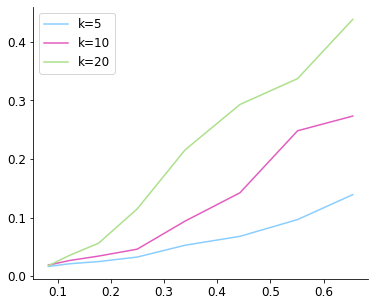

In [193]:
SIR_colors = {
    "1": "#8aceff",
    "2": "#e35dbf",
    "3": "#ace08b"
}

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.plot(
    Ts,
    risultati[0]/150.,
    c=SIR_colors["1"],
    label="k=5"
)
ax.plot(
    Ts,
    risultati[1]/150.,
    c=SIR_colors["2"],
    label="k=10"
)
ax.plot(
    Ts,
    risultati[2]/150.,
    c=SIR_colors["3"],
    label="k=20"
)
ax.legend(loc="upper left")

### Exercise 5.15
Approximately find the critical transmissibility $T_c$ for different values of $\kappa$ in yourr simulations, and compare your results to those of the manuscript. Are they similar? Since we are simulating a smaller system, we do not expect a perfect match, but we do expect a similar qualitative behaviouor.

My $T_c$ falls, for the same parameters, in a similar intervall to Newmann's (my simulation has a very coarse sampling of $T$)

### Exercise 5.16
Explain why $T_c$ decreases when $\kappa$ is increased. How is this related to the presence of super-spreaders, and how do they impact the global epidemic dynamics?

Increasing $\kappa$ decreases the cutoff in the distribution of relations between individuals. This means that each individual is on average in comunication with more people. Increased $\kappa$ increases the odds of a node being a _superspreader_, i.e. a node with lots of connections with makes it easier for the epidemic to evolve into a pandemic
    